<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Graph RAG <br>

*`Full Name:`* Fatemeh Shahhosseini

*`SID:`* 403206519


----




In this Notebook, we'll explore the implementation of the GraphRAG (Graph-based Retrieval-Augmented Generation) approach to query-focused summarization, as described in the research paper `"From Local to Global: A GraphRAG Approach to Query-Focused Summarization"` by Darren Edge et al. This method is designed to generate comprehensive and diverse answers to global questions over entire text corpora by leveraging a graph-based text index and an LLM (Large Language Model).

We'll walk through a Python-based implementation that includes key steps from the paper, demonstrating how to process documents, build a graph, detect communities, and generate a final answer to a query.

Overview of the proposed Pipeline:
![GraphRAG](https://drive.google.com/uc?export=view&id=16Pv1vt_yY6u9ARodmnkbRmQttcpnjB18)

In [1]:
!pip install -q networkx leidenalg cdlib python-igraph pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.5 MB/s eta 0:00:00


In [2]:
%%capture --no-stderr
!pip install langchain-opentutorial

In [3]:
!pip install langchain

In [4]:
from langchain_opentutorial import package

package.install(
    [
        "langchain_core",
        "langchain_community",
        # "langchain-graphrag",

    ],
    verbose=False,
    upgrade=False,
)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and save sample PDF file to ./data directory
import requests
import os

def download_pdf(url, save_path):
    """
    Downloads a PDF file from the given URL and saves it to the specified path.

    Args:
        url (str): The URL of the PDF file to download.
        save_path (str): The full path (including file name) where the file will be saved.
    """
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an error for bad status codes

        # Save the file to the specified path
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

        print(f"PDF downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")

# Configuration for the PDF file
pdf_url = "https://arxiv.org/pdf/2404.16130v1"
file_path = "/content/drive/MyDrive/GraphRag/data/2404.16130v1.pdf"

# Download the PDF
# download_pdf(pdf_url, file_path)

# Load the GraphRAG paper using PyPDFLoader.
# PyPDFLoader loads PDF content on a per-page basis.
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
docs = loader.load()
print(f"Loaded {len(docs)} documents.")
print(docs[0].page_content)

Loaded 15 documents.
From Local to Global: A Graph RAG Approach to
Query-Focused Summarization
Darren Edge1† Ha Trinh1† Newman Cheng2 Joshua Bradley2 Alex Chao3
Apurva Mody3 Steven Truitt2
Jonathan Larson1
1Microsoft Research
2Microsoft Strategic Missions and Technologies
3Microsoft Office of the CTO
{daedge,trinhha,newmancheng,joshbradley,achao,moapurva,steventruitt,jolarso}
@microsoft.com
†These authors contributed equally to this work
Abstract
The use of retrieval-augmented generation (RAG) to retrieve relevant informa-
tion from an external knowledge source enables large language models (LLMs)
to answer questions over private and/or previously unseen document collections.
However, RAG fails on global questions directed at an entire text corpus, such
as “What are the main themes in the dataset?”, since this is inherently a query-
focused summarization (QFS) task, rather than an explicit retrieval task. Prior
QFS methods, meanwhile, fail to scale to the quantities of text indexed by 

## dependancy resolving

In [24]:
!pip install "numpy==1.26.4" "scipy==1.12.0" --force-reinstall --no-cache-dir
# !pip install --upgrade langchain langchain_graphrag

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 241.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 241.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 246.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatib

In [ ]:
!pip uninstall -y langchain_graphrag numpy

Found existing installation: langchain-graphrag 0.0.9
Uninstalling langchain-graphrag-0.0.9:
  Successfully uninstalled langchain-graphrag-0.0.9
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [26]:
!pip install numpy==1.26.4 --no-cache-dir

In [ ]:
from langchain_graphrag.indexing import TextUnitExtractor
print("Imported successfully!")

## Cont.

In [ ]:
from langchain_core.documents import Document
from langchain_graphrag.indexing import TextUnitExtractor
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
text_unit_extractor = TextUnitExtractor(text_splitter=splitter)

# This runs the text splitting logic on the loaded PDF pages
df_text_units = text_unit_extractor.run(docs)
df_text_units

Extracting text units ...: 100%|██████████| 6/6 [00:00<00:00, 24552.02it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 59811.82it/s]

Extracting text units ...: 100%|██████████| 7/7 [00:00<00:00, 58956.08it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 70690.52it/s]

Extracting text units ...: 100%|██████████| 7/7 [00:00<00:00, 61680.94it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 68478.43it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 66576.25it/s]

Extracting text units ...: 100%|██████████| 10/10 [00:00<00:00, 76538.39it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 69615.00it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 74017.13it/s]

Extracting text units ...: 100%|██████████| 9/9 [00:00<00:00, 78316.88it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 71544.63it/s]

Extracting text units ...: 100%|██████████| 8/8 [00:00<00:00, 70344.72it/s

,document_id,id,text_unit
0,34d76e7a-31f6-4a4c-8fae-918229363006,a736a63a-9565-44eb-81a2-90603acbf4a7,From Local to Global: A Graph RAG Approach to\...
1,34d76e7a-31f6-4a4c-8fae-918229363006,224a2b66-09d6-4f66-a91d-980a3ba37395,tion from an external knowledge source enables...
2,34d76e7a-31f6-4a4c-8fae-918229363006,3cc59e79-9140-41d9-bbdd-1d1b60e67993,RAG systems. To combine the strengths of these...
3,34d76e7a-31f6-4a4c-8fae-918229363006,e3b39e5e-49ce-4d53-8156-f38d7c23e526,"question, each community summary is used to ge..."
4,34d76e7a-31f6-4a4c-8fae-918229363006,aac6c7c8-c585-4213-a6c0-b493a2465aa0,approaches is forthcoming at https://aka.ms/gr...
...,...,...,...
110,7153d44b-f558-4b86-a820-a4d5083053f4,24878138-eb3b-4a4f-b13c-9d77f7d954e4,well-connected communities. Scientific Reports...
111,7153d44b-f558-4b86-a820-a4d5083053f4,d3642656-5113-4b05-b1ec-f611e0df665d,a good nlg evaluator? a preliminary study. arX...
112,7153d44b-f558-4b86-a820-a4d5083053f4,13dcf164-671f-4cce-bb53-a3b3c8dbf71c,"arXiv:2106.00104.\nYang, Z., Qi, P., Zhang, S...."
113,17e058f8-b829-4ca3-99e7-df4df1bbe354,b8ef4b62-dda9-4e4e-9b4d-320d5f7abbb9,"Yao, L., Peng, J., Mao, C., and Luo, Y . (2023..."


In [ ]:
df_text_units.to_csv("/content/drive/MyDrive/GraphRag/df_text_units.csv", index=False)

In [ ]:
import pandas as pd
df_text_units = pd.read_csv("df_text_units.csv")

In [9]:
!pip install cdlib

In [30]:
!pip install --upgrade transformers accelerate einops

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import networkx as nx
from cdlib import algorithms
import os


model_name = "Qwen/Qwen3-4B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
def get_response(prompt, content):
    messages = [
    {"role": "user", "content": content + ' Do not include any additional and irrelevant information. \t' + prompt}
]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=32768
    )
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    response = tokenizer.decode(output_ids[0:], skip_special_tokens=True).strip("\n")
    return response

get_response('hi', '')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap'}


tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

'hi'

`1. Text Chunks → Element Instances`

  First, we'll extract entities and relationships from each chunk of text using Qwen

In [ ]:
df_text_units['text_unit']

,text_unit
0,From Local to Global: A Graph RAG Approach to\...
1,tion from an external knowledge source enables...
2,RAG systems. To combine the strengths of these...
3,"question, each community summary is used to ge..."
4,approaches is forthcoming at https://aka.ms/gr...
...,...
110,well-connected communities. Scientific Reports...
111,a good nlg evaluator? a preliminary study. arX...
112,"arXiv:2106.00104.\nYang, Z., Qi, P., Zhang, S...."
113,"Yao, L., Peng, J., Mao, C., and Luo, Y . (2023..."


In [ ]:
len(df_text_units['text_unit'])

115

In [ ]:
from tqdm import tqdm
import json
output_path = "/content/drive/MyDrive/GraphRag/entities_and_relations.jsonl"

def extract_element_Instances(chunks):
    """
      Inputs:
        chunks (list of str): List of text chunks.
      Output:
        List of extracted elements (entity-relationship data).
    """
    elements = []
    with open(output_path, 'a', encoding='utf-8') as f:
      for index, chunk in tqdm(enumerate(chunks)):

          ############### Your Code - 5pts #############################
          content = (
              "Extract all named entities and their relationships from the text. "
              "Return the result in the following format:\n\n"
              "**Entities:**\n"
              "- Entity 1\n"
              "- Entity 2\n"
              "- ...\n\n"
              "**Relationships:**\n"
              "- Subject 1 is related to Object 1 in some way.\n"
              "- ...\n\n"
              "Only include relevant named entities and relationships.\n\n"
              "### Example Output:\n\n"
              "**Entities:**\n"
              "- Jonathan Larson\n"
              "- Microsoft Research\n"
              "- Microsoft Strategic Missions and Technologies\n"
              "- @microsoft.com\n"
              "- A Graph RAG Approach to Query-Focused Summarization\n"
              "- Retrieval-augmented generation (RAG)\n"
              "- Large language models (LLMs)\n"
              "- External knowledge source\n\n"
              "**Relationships:**\n"
              "- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, and Jonathan Larson are authors of the paper.\n"
              "- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, and Steven Truitt contributed equally to this work.\n"
              "- The paper is titled \"From Local to Global: A Graph RAG Approach to Query-Focused Summarization.\"\n"
              "- The paper is published by Microsoft Research, Microsoft Strategic Missions and Technologies, and Microsoft Office of the CTO.\n"
              "- The authors are associated with the email addresses {daedge, trinhha, newmancheng, joshbradley, achaoo, moapurva, steventruitt, jolarso} and @microsoft.com.\n"
              "- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.\n"
              "- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.\n\n"
          )
          #######################################################
          entities_and_relations = get_response(chunk, content)
          elements.append(entities_and_relations)

          parse_and_store_blocks(entities_and_relations, output_path)
          print(entities_and_relations)

    return elements


elements = extract_element_Instances(df_text_units['text_unit'][53:])

1it [00:11, 11.62s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Table 2
- LLM-generated assessment
- LLMs
- Comparison
- Mean scores
- Stochasticity

**Relationships:**
- We run each comparison five times and use mean scores to account for stochasticity.
- Table 2 shows an example of LLM-generated assessment.


2it [00:26, 13.30s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- The entertainment industry
- Film
- Television
- Music
- Sports
- Digital media
- Public figures

**Relationships:**
- The entertainment industry encompasses film, television, music, sports, and digital media.
- Certain public figures stand out due to their significant contributions and influence across these sectors.
- Public figures are repeatedly mentioned in various entertainment articles.


3it [00:41, 14.05s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Entertainment articles
- Public figures
- Cultural narratives
- Film and television
- Music
- Digital media
- Influence

**Relationships:**
- Entertainment articles mention public figures.
- Public figures influence cultural narratives.
- Public figures shape cultural narratives in film and television.
- Public figures drive trends in music and digital media.
- Public figures influence the broader cultural aspects.


4it [00:55, 14.07s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Taylor Swift
- Travis Kelce
- Britney Spears
- Justin Timberlake
- RAG
- Naïve

**Relationships:**
- Taylor Swift, Travis Kelce, Britney Spears, and Justin Timberlake are public figures who are repeatedly mentioned across various entertainment articles.
- RAG is mentioned in the context of Naïve.


5it [01:33, 23.01s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Taylor Swift
- Travis Kelce
- Britney Spears
- Justin Timberlake
- Large language models (LLMs)
- Decision
- Comprehensiveness
- Graph RAG
- Public figures
- Media coverage
- Public reactions
- Cultural impacts
- Economic impacts

**Relationships:**
- Taylor Swift, Travis Kelce, Britney Spears, and Justin Timberlake are public figures.
- Taylor Swift, Travis Kelce, Britney Spears, and Justin Timberlake are frequently covered due to their high-profile status.
- Taylor Swift, Travis Kelce, Britney Spears, and Justin Timberlake have significant cultural and economic impacts.
- Their activities, whether in music, sports, or personal relationships, have significant cultural and economic impacts.
- Media coverage and public reactions are evidence of the impact of Taylor Swift, Travis Kelce, Britney Spears, and Justin Timberlake.
- Comprehensiveness is a metric used to evaluate the answer.
- Decis

6it [01:56, 22.77s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Film
- Television
- Music
- Sports
- Gaming
- Digital media
- Graph RAG
- Entertainment industry
- Public figures
- Personal lives
- Relationships
- Professional influence
- Controversies
- Implications
- Diversity

**Relationships:**
- Film is part of the entertainment industry.
- Television is part of the entertainment industry.
- Music is part of the entertainment industry.
- Sports is part of the entertainment industry.
- Gaming is part of the entertainment industry.
- Digital media is part of the entertainment industry.
- Graph RAG is a winner in the Diversity category.


7it [02:44, 30.95s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- A Graph RAG Approach to Query-Focused Summarization
- @microsoft.com
- Darren Edge
- Ha Trinh
- Newman Cheng
- Joshua Bradley
- Alex Chao
- Apurva Mody
- Steven Truitt
- Jonathan Larson

**Relationships:**
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, and Jonathan Larson are authors of the paper.
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, and Steven Truitt contributed equally to this work.
- The paper is titled "A Graph RAG Approach to Query-Focused Summarization."
- The paper is published by Microsoft Research, Microsoft Strategic Missions and Technologies, and Microsoft Office of the CTO.
- The author

8it [03:06, 28.19s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Public figures
- Entertainment industry
- Film
- Television
- Music
- Sports
- Digital media

**Relationships:**
- Graph RAG is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- Public figures are part of the entertainment industry.
- The entertainment industry includes film, television, music, sports, and digital media.


9it [03:32, 27.49s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Answer 1
- Answer 2
- Naïve RAG
- Entertainment articles
- Data reports
- Public figures
- Personal lives
- Relationships
- Breadth of the topic
- Informed judgments
- Misled
- Depth
- Variety

**Relationships:**
- Answer 1 provides a broader understanding of the topic compared to Answer 2.
- Answer 2 focuses on a smaller group of public figures and primarily discusses their personal lives and relationships.
- Answer 1 cites sources, including entertainment articles and data reports, to support its claims.
- Answer 2 also cites sources but does not match the depth and variety of Answer 1.
- Naïve RAG is the directness winner in the comparison between Answer 1 and Answer 2.


10it [03:44, 22.66s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Taylor Swift
- Travis Kelce
- Britney Spears
- Justin Timberlake

**Relationships:**
- Taylor Swift, Travis Kelce, Britney Spears, and Justin Timberlake are frequently mentioned in various entertainment articles.


11it [03:59, 20.55s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Table 2
- Example question for the News article dataset
- Graph RAG
- Naïve RAG
- LLM-generated assessments

**Relationships:**
- Table 2 includes an example question for the News article dataset.
- Graph RAG is used to generate answers for the example question.
- Naïve RAG is used to generate answers for the example question.
- LLM-generated assessments are provided for the example question.


12it [04:38, 25.90s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Comprehensiveness
- Diversity
- Empowerment

**Relationships:**
- Comprehensiveness is measured by the values 50 18 23 25 19 19, 82 50 50 50 43 46, 77 50 50 50 46 44, 75 50 50 50 44 45, 81 57 54 56 50 48, 81 54 56 55 52 50.
- Diversity is measured by the values 50 42 57 52 49 51, 58 50 59 55 52 51, 43 41 50 49 47 48, 48 45 51 50 49 50, 51 48 53 51 50 51, 49 49 52 50 49 50.
- Empowerment is measured by the values 50 56 65 60 60 60, 44 50 55 52 51 52, 35 45 50 47 48 48, 40 48 53 50 50 50, 40 49 52 50 50 50, 40 48 52 50 50 50.


13it [05:02, 25.39s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Directness
- News articles
- Comprehensiveness
- Diversity

**Relationships:**
- Directness is measured using the metrics 50, 20, 28, 25, 21, 21.
- Comprehensiveness is measured using the metrics 50, 33, 38, 35, 29, 31.
- Diversity is measured using the metrics 50, 47, 57, 49, 50, 50.


14it [05:23, 23.99s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Empowerment
- Directness
- Figure 4
- Head-to-head win rate percentages
- Row condition
- Column condition
- Datasets
- Metrics
- Questions
- Self-win rates

**Relationships:**
- Figure 4 shows head-to-head win rate percentages across two datasets, four metrics, and 125 questions per comparison.
- The overall winner per dataset and metric is shown in bold in Figure 4.
- Head-to-head win rate percentages are calculated across two datasets, four metrics, and 125 questions per comparison.


15it [05:51, 25.38s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG
- RAG
- Large language models (LLMs)
- External knowledge source
- gpt-4-turbo
- Context window size
- Comprehensiveness
- Diversity
- TS (global text summarization without a graph index)
- Self-win rate

**Relationships:**
- Graph RAG outperformed naive RAG on comprehensiveness and diversity.
- Conditions C1-C3 showed slight improvements in answer comprehensiveness and diversity over TS.
- The effect of context window size on any particular task is unclear, especially for models like gpt-4-turbo with a large context size of 128k tokens.
- Self-win rates were not computed but are shown as the expected 50% for reference.


16it [06:26, 28.11s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- GPT-4-Turbo
- 128k tokens
- Kuratov et al., 2024
- Liu et al., 2023
- Context window size
- Datasets
- Questions
- Metrics
- Baseline condition (SS)
- LLM use

**Relationships:**
- GPT-4-Turbo has a large context size of 128k tokens.
- Kuratov et al., 2024 and Liu et al., 2023 discuss the potential for information to be “lost in the middle” of longer contexts.
- The study explores the effects of varying the context window size for combinations of datasets, questions, and metrics.
- The goal is to determine the optimum context size for the baseline condition (SS) and use it uniformly for all query-time LLM use.
- Four context window sizes were tested: 8k, 16k, 32k, and 64k.


17it [06:52, 27.45s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- 8k
- 16k
- 32k
- 64k
- Comprehensiveness
- Diversity
- Empowerment
- Podcast
- Context window size
- Final evaluation

**Relationships:**
- The smallest context window size tested (8k) was universally better for all comparisons on comprehensiveness.
- The context window size of 8k performed comparably with larger context sizes on diversity.
- The context window size of 8k performed comparably with larger context sizes on empowerment.
- Given the preference for more comprehensive and diverse answers, a fixed context window size of 8k tokens was used for the final evaluation.
- The indexing process resulted in a graph consisting of 8564 nodes and 20691 edges for the Podcast.


18it [07:19, 27.41s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Podcast dataset
- News dataset
- Global approaches
- Naïve RAG (SS)
- Comprehensiveness
- Diversity

**Relationships:**
- The indexing process resulted in a graph with 8564 nodes and 20691 edges for the Podcast dataset, and a larger graph with 15754 nodes and 19520 edges for the News dataset.
- Table 3 shows the number of community summaries at different levels of each graph community hierarchy.
- Global approaches consistently outperformed the naïve RAG (SS) approach in both comprehensiveness and diversity metrics across datasets.
- Global approaches achieved comprehensiveness win rates between 72-83%.


19it [07:42, 26.00s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Global approaches
- Podcast transcripts
- News articles
- Directness
- Retrieval-augmented generation (RAG)
- Naïve RAG

**Relationships:**
- Global approaches achieved comprehensiveness win rates between 72-83% for Podcast transcripts and 72-80% for News articles.
- Diversity win rates ranged from 75-82% and 62-71% respectively for Podcast transcripts and News articles.
- Directness was used as a validity test.
- Naïve RAG produced the most direct responses across all comparisons.


20it [08:04, 24.90s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- C0
- C1
- C2
- C3
- TS
- Table 3
- Context units
- Tokens
- Percentage of the maximum token count
- Map-reduce summarization
- Source texts

**Relationships:**
- Table 3 contains the number of context units (community summaries for C0-C3 and text chunks for TS), corresponding token counts, and percentage of the maximum token count.
- Map-reduce summarization is described as the most resource-intensive approach.
- Map-reduce summarization requires the highest number of context tokens.


21it [08:30, 25.34s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Root-level community summaries (C0)
- Community summaries
- Source texts
- Graph RAG
- Intermediate-level summaries
- Podcast dataset
- Low-level community summaries
- News dataset

**Relationships:**
- Root-level community summaries (C0) require dramatically fewer tokens per query (9x-43x).
- Community summaries generally provided a small but consistent improvement in answer comprehensiveness and diversity compared to source texts using Graph RAG, except for root-level summaries.
- Intermediate-level summaries in the Podcast dataset achieved a comprehensiveness win rate of 57%.
- Low-level community summaries in the News dataset achieved a comprehensiveness win rate of 64%.
- Diversity win rates were 57% for community summaries compared to source texts using Graph RAG.


22it [08:54, 24.79s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG
- Source text summarization
- Low-level community summaries (C3)
- Root-level community summaries (C0)
- Podcast intermediate-level summaries
- News low-level community summaries
- Table 3

**Relationships:**
- Graph RAG is more scalable than source text summarization.
- Graph RAG requires 26-33% fewer context tokens for low-level community summaries (C3).
- Graph RAG requires over 97% fewer tokens for root-level community summaries (C0).
- Graph RAG has a modest drop in performance compared with other global methods.
- Graph RAG offers a highly efficient approach for root-level community summaries.


23it [09:27, 27.19s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Root-level Graph RAG
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Sensemaking activity
- Iterative question answering
- Comprehensiveness
- Diversity
- Global methods
- Naïve RAG
- SS (source text summarization)
- TS (source text summarization)
- Empowerment

**Relationships:**
- Root-level Graph RAG offers a highly efficient method for iterative question answering that characterizes sensemaking activity.
- Root-level Graph RAG retains advantages in comprehensiveness (72% win rate) and diversity (62% win rate) over naïve RAG.
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- Empowerment comparisons showed mixed 

24it [09:53, 26.85s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Large language models (LLMs)
- Retrieval-augmented generation (RAG)
- External knowledge source
- Graph RAG index
- Exam examples
- Quotes
- Citations
- LLM reasoning
- Graph RAG approach
- Query-focused summarization

**Relationships:**
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- The Graph RAG index is used to retain more details such as exam examples, quotes, and citations.
- LLM reasoning is analyzed using the Graph RAG approach to query-focused summarization.


25it [10:24, 28.11s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Ram et al., 2023
- Gao et al., 2023
- Retrieval-augmented generation (RAG)
- External knowledge source
- Large language models (LLMs)
- Vector space
- Text chunks
- Context window

**Relationships:**
- Ram et al., 2023 discuss naive RAG approaches.
- Gao et al., 2023 describe naive RAG approaches.
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are affected by the context window limitation.
- The context window limitation is addressed by using retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- Text chunks are converted into a vector space.
- Queries are embedded into the same vector space as text chunks.
- The nearest k vectors in the vector space are used as context for queries.


26it [10:52, 28.19s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- External dataset
- LLM’s context window
- Naïve RAG
- Modular RAG
- Graph RAG
- Selfmem
- Cheng et al., 2024
- Gao et al., 2023

**Relationships:**
- The problem is what to do when an external dataset exceeds the LLM’s context window.
- Graph RAG incorporates multiple concepts related to other systems.
- Graph RAG includes concepts related to Selfmem.
- Selfmem is a concept introduced by Cheng et al., 2024.
- Modular RAG systems include patterns for iterative and dynamic cycles of interleaved retrieval and generation.
- Advanced RAG systems include pre-retrieval, retrieval, and post-retrieval strategies to overcome the drawbacks of Naïve RAG.


27it [11:53, 38.08s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Selfmem
- Cheng
- Generation-augmented retrieval (GAR)
- Mao
- 2020
- Iter-RetGen
- Shao
- 2023
- Federated (FeB4RAG)
- Wang
- 2024
- Multi-document summarization (CAiRE-COVID)
- Su
- 2020
- Multi-hop question answering (ITRG)
- Feng
- 2023
- IR-CoT
- Trivedi
- 2022
- DSP
- Khattab

**Relationships:**
- Selfmem is mentioned in the context of being a kind of self-memory for generation-augmented retrieval.
- Cheng is associated with the Selfmem concept in 2024.
- Generation-augmented retrieval (GAR) is mentioned in the context of being a concept combined with self-memory.
- Mao is associated with the Generation-augmented retrieval (GAR) concept in 2020.
- Iter-RetGen is mentioned in the context of being an iterative retrieval-generation strategy.
- Shao is associated with the Iter-RetGen concept in 2023.
- Federated (FeB4RAG) is mentioned in the context of being a federated retrieval-generati

28it [12:40, 40.84s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- multi-hop question answering
- ITRG (Feng et al., 2023)
- IR-CoT (Trivedi et al., 2022)
- DSP (Khattab et al., 2022)
- RAPTOR (Sarthi et al., 2024)
- “tree of clarifications” (Kim et al., 2023)
- Graph RAG
- ITRG
- IR-CoT
- DSP
- RAPTOR
- “tree of clarifications”

**Relationships:**
- multi-hop question answering is associated with ITRG (Feng et al., 2023), IR-CoT (Trivedi et al., 2022), and DSP (Khattab et al., 2022).
- The use of a hierarchical index and summarization in Graph RAG resembles approaches such as generating a hierarchical index of text chunks by clustering the vectors of text embeddings (RAPTOR, Sarthi et al., 2024) or generating a “tree of clarifications” to answer multiple interpretations of ambiguous questions (Kim et al., 2023).
- Graph RAG is distinct from iterative or hierarchical approaches like ITRG (Feng et al., 2023), IR-CoT (Trivedi et al., 2022), DSP (Khattab et a

29it [13:04, 35.75s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graphs
- LLMs
- RAG
- Knowledge graph creation
- Completion
- Causal graphs
- Advanced RAG
- Knowledge graph (KAPING)
- Subsets of the graph structure (G-Retriever)
- Derived graph metrics (Graph-)

**Relationships:**
- Graphs are used in connection with LLMs and RAG.
- LLMs are used for knowledge graph creation.
- LLMs are used for completion.
- LLMs are used for the extraction of causal graphs.
- Advanced RAG is used where the index is a knowledge graph.
- Subsets of the graph structure are used in advanced RAG.
- Derived graph metrics are used in advanced RAG.


30it [13:39, 35.33s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- ToolFormer
- Zhang
- 2023
- SURGE
- Kang
- 2023
- FABULA
- Ranade
- Joshi
- 2023
- Wang
- 2023b
- LangChain
- 2024
- LlamaIndex
- 2024

**Relationships:**
- ToolFormer, Zhang, and 2023 are the objects of enquiry.
- Narrative outputs are strongly grounded in the facts of retrieved subgraphs (SURGE, Kang, 2023).
- Retrieved event-plot subgraphs are serialized using narrative templates (FABULA, Ranade and Joshi, 2023).
- The system supports both creation and traversal of text-relationship graphs for multi-hop question answering (Wang, 2023b).
- A variety of graph databases are supported by both the LangChain (2024) and LlamaIndex (2024) libraries.


31it [14:04, 32.46s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- LangChain
- LlamaIndex
- Neo4J
- NebulaGraph
- GraphRAG
- Natural modularity of graphs
- Global summarization
- Knowledge graphs

**Relationships:**
- LangChain is supported by the paper.
- LlamaIndex is supported by the paper.
- A more general class of graph-based RAG applications is emerging.
- Systems that can create and reason over knowledge graphs in Neo4J format are part of the emerging applications.
- Systems that can create and reason over knowledge graphs in NebulaGraph format are part of the emerging applications.
- GraphRAG is a graph-based RAG approach that uses the natural modularity of graphs to partition data for global summarization.
- Unlike GraphRAG, none of the other systems use the natural modularity of graphs to partition data for global summarization.


32it [14:27, 29.57s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Evaluation approach
- Sensemaking questions
- Corpora
- 1 million tokens
- SelfCheckGPT
- Manakul et al., 2023
- End users

**Relationships:**
- The evaluation approach has examined a certain class of sensemaking questions for two corpora in the region of 1 million tokens.
- More work is needed to understand how performance varies across different ranges of question types, data types, and dataset sizes.
- The evaluation approach needs to be validated with end users.
- Comparison of fabrication rates using approaches like SelfCheckGPT (Manakul et al., 2023) would improve the current analysis.


33it [14:48, 27.02s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG
- Other methods
- Graph-free approach
- Source texts
- Compute budget
- Lifetime queries
- Graph index
- Other aspects of the graph index

**Relationships:**
- Graph RAG achieves the best head-to-head results against other methods.
- The graph-free approach to global summarization of source texts performed competitively.
- The decision to invest in building a graph index depends on the compute budget.
- The decision to invest in building a graph index depends on the expected number of lifetime queries per dataset.
- The decision to invest in building a graph index depends on the value obtained from other aspects of the graph index.


34it [15:14, 26.57s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG Approach to Query-Focused Summarization
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Graph index
- Rich text annotations
- Hierarchical community structure
- User queries
- Community reports
- Map-reduce summarization

**Relationships:**
- The graph index, rich text annotations, and hierarchical community structure support the current Graph RAG approach.
- The Graph RAG approach includes RAG approaches that operate in a more local manner, via embedding-based matching of user queries and graph annotations.
- The Graph RAG approach includes hybrid RAG schemes that combine embedding-based matching against community reports before employing map-reduce summarization.


35it [15:40, 26.56s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG
- Retrieval-augmented generation (RAG)
- Query-focused summarization (QFS)
- Knowledge graph generation
- Community reports
- Community hierarchy
- Information scent
- Human

**Relationships:**
- Graph RAG combines knowledge graph generation, retrieval-augmented generation (RAG), and query-focused summarization (QFS).
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Query-focused summarization (QFS) is supported by the global approach to Graph RAG.
- Community reports are used in embedding-based matching against community reports before employing our map-reduce summa-rization mechanisms.
- The “roll-up” operation can be extended across more levels of the community hierarchy.
- The “drill down” mechanism follows the information scent contained in higher-level community summaries.
- The global approach to Graph RAG 

36it [16:08, 26.97s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Retrieval-augmented generation (RAG)
- Query-focused summarization (QFS)
- Human sensemaking
- Text corpora
- Na¨ıve RAG baseline
- Global approach
- Map-reduce source text summarization
- Entity-based graph index
- Root-level communities

**Relationships:**
- Retrieval-augmented generation (RAG) and query-focused summarization (QFS) are used to support human sensemaking over entire text corpora.
- Initial evaluations show substantial improvements over a na¨ıve RAG baseline for both the comprehensiveness and diversity of answers.
- Initial evaluations show favorable comparisons to a global but graph-free approach using map-reduce source text summarization.
- Summaries of root-level communities in the entity-based graph index provide a data index that is both superior to na¨ıve RAG.


37it [16:44, 29.50s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Graph RAG Approach to Query-Focused Summarization
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Graph RAG
- Open-source, Python-based implementation
- https://aka.ms/graphrag

**Relationships:**
- The paper titled "From Local to Global: A Graph RAG Approach to Query-Focused Summarization" is published by Microsoft Research, Microsoft Strategic Missions and Technologies, and Microsoft Office of the CTO.
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- An open-source, Python-based implementation of both global and lo

38it [17:21, 31.72s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Alonso Guevara Fernandez
- Amber Hoak
- Andrés Morales Esquivel
- Ben Cutler
- Billie Rinaldi
- Chris Sanchez
- Chris Trevino
- Christine Caggiano
- David Tittsworth
- Dayenne de Souza
- Douglas Orbaker
- Ed Clark
- Gabriel Nieves-Ponce
- Gaudy Blanco Meneses
- Kate Lytvynets
- Katy Smith
- Monica Carvaljal
- Nathan Evans
- Richard Ortega
- Rodrigo Racanicci
- Sarah Smith
- Shane Solomon

**Relationships:**
- Alonso Guevara Fernandez, Amber Hoak, Andrés Morales Esquivel, Ben Cutler, Billie Rinaldi, Chris Sanchez, Chris Trevino, Christine Caggiano, David Tittsworth, Dayenne de Souza, Douglas Orbaker, Ed Clark, Gabriel Nieves-Ponce, Gaudy Blanco Meneses, Kate Lytvynets, Katy Smith, Monica Carvaljal, Nathan Evans, Richard Ortega, Rodrigo Racanicci, Sarah Smith, and Shane Solomon contributed to the work.


39it [18:11, 37.35s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Achiam, J.
- Adler, S.
- Agarwal, S.
- Ahmad, L.
- Akkaya, I.
- Aleman, F. L.
- Almeida, D.
- Altenschmidt, J.
- Altman, S.
- Anadkat, S.
- Anil, R.
- Borgeaud, S.
- Wu, Y.
- Alayrac, J.-B.
- Yu, J.
- Soricut, R.
- Schalkwyk, J.
- Dai, A. M.
- Hauth, A.
- Baek, J.
- Aji, A. F.
- Saffari, A.

**Relationships:**
- Achiam, J., Adler, S., Agarwal, S., Ahmad, L., Akkaya, I., Aleman, F. L., Almeida, D., Altenschmidt, J., Altman, S., Anadkat, S., et al. authored the "Gpt-4 technical report."
- Anil, R., Borgeaud, S., Wu, Y., Alayrac, J.-B., Yu, J., Soricut, R., Schalkwyk, J., Dai, A. M., Hauth, A., et al. authored the "Gemini: a family of highly capable multimodal models."
- Baek, J., Aji, A. F., and Saffari, A. authored the "Knowledge-augmented language model prompting for zero-shot knowledge graph question answering."


40it [19:13, 44.82s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- T. Ban
- L. Chen
- X. Wang
- H. Chen
- T. Baumel
- M. Eyal
- M. Elhadad
- V. D. Blondel
- J.-L. Guillaume
- R. Lambiotte
- E. Lefebvre
- "From query tools to causal architects: Harnessing large language models for advanced causal discovery from data."
- "Query focused abstractive summarization: Incorporating query relevance, multi-document coverage, and summary length constraints into seq2seq models."
- arXiv:2306.04136
- arXiv:1801.07704
- Large language models
- Causal discovery
- Query focused abstractive summarization
- Seq2seq models
- External knowledge source
- Retrieval-augmented generation (RAG)
- Graph RAG Approach to Query-Focused Summarization

**Relationships:**
- T. Ban, L. Chen, X. Wang, and H. Chen are authors of the paper "From query tools to causal architects: Harnessing large language models for advanced causal discovery from data."
- T. Baumel, M. Eyal, and M. Elhadad ar

41it [19:56, 44.16s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Blondel, V. D.
- Guillaume, J.-L.
- Lambiotte, R.
- Lefebvre, E.
- Brown, T.
- Mann, B.
- Ryder, N.
- Subbiah, M.
- Kaplan, J. D.
- Dhariwal, P.
- Neelakantan, A.
- Shyam, P.
- Sastry, G.
- Askell, A.
- Cheng, X.
- Luo, D.
- Chen, X.
- Liu, L.
- Zhao, D.
- Yan, R.

**Relationships:**
- Blondel, V. D., Guillaume, J.-L., Lambiotte, R., and Lefebvre, E. authored the paper "Fast unfolding of communities in large networks."
- Brown, T., Mann, B., Ryder, N., Subbiah, M., Kaplan, J. D., Dhariwal, P., Neelakantan, A., Shyam, P., Sastry, G., Askell, A., et al. authored the paper "Language models are few-shot learners."
- Cheng, X., Luo, D., Chen, X., Liu, L., Zhao, D., and Yan, R. authored the paper "Lift yourself up: Retrieval-..."


42it [21:05, 51.48s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Cheng, X.
- Luo, D.
- Chen, X.
- Liu, L.
- Zhao, D.
- Yan, R.
- Dang, H. T.
- Es, S.
- James, J.
- Espinosa-Anke, L.
- Schockaert, S.
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Question-focused summarization systems
- Task-Focused Summarization and Question Answering
- Ragas
- arXiv preprint arXiv:2309.15217
- Advances in Neural Information Processing Systems, 36
- Duc 2005

**Relationships:**
- Cheng, X., Luo, D., Chen, X., Liu, L., Zhao, D., and Yan, R. authored the paper "Lift yourself up: Retrieval-augmented text generation with self-memory."
- Dang, H. T. authored the paper "Duc 2005: Evaluation of question-focused summarization systems."
- Es, S., James, J., Espinosa-Anke, L., and Schockaert, S. developed the system "Ragas: Automated evaluation of retrieval augmented generation."
- "Ragas: Automated evaluation of retrieval augme

43it [21:49, 49.45s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Feng, Z.
- Feng, X.
- Zhao, D.
- Yang, M.
- Qin, B.
- Fortunato, S.
- Community detection in graphs
- Gao, Y.
- Xiong, Y.
- Gao, X.
- Jia, K.
- Pan, J.
- Bi, Y.
- Dai, Y.
- Sun, J.
- Wang, H.

**Relationships:**
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- Feng, Z., Feng, X., Zhao, D., Yang, M., and Qin, B. (2023) proposed Retrieval-generation synergy augmented large language models.
- Fortunato, S. (2010) wrote "Community detection in graphs."
- Gao, Y., Xiong, Y., Gao, X., Jia, K., Pan, J., Bi, Y., Dai, Y., Sun, J., and Wang, H. (2023) conducted a survey on retri

44it [22:51, 53.04s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- A Graph RAG Approach to Query-Focused Summarization
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- arXiv:2312.10997
- T. R. Goodwin
- M. E. Savery
- D. Demner-Fushman
- COLING
- International Conference on Computational Linguistics
- X. He
- Y. Tian
- Y. Sun
- N. V. Chawla
- T. Laurent
- Y. LeCun
- X. Bresson
- B. Hooi

**Relationships:**
- "A Graph RAG Approach to Query-Focused Summarization" is an arXiv preprint with the identifier arXiv:2312.10997.
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- T. R. Goodwin, M. E. Savery, and D. Demner-Fushman authored the paper "Flight of the pegasus? comparing transformer

45it [23:17, 44.88s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- G-retriever
- Retrieval-augmented generation (RAG)
- Textual graph understanding
- Question answering
- arXiv preprint
- arXiv:2402.07630

**Relationships:**
- G-retriever is a type of Retrieval-augmented generation (RAG).
- G-retriever is used for textual graph understanding and question answering.
- G-retriever is described as a retrieval-augmented generation for textual graph understanding and question answering.
- The paper is titled "G-retriever: Retrieval-augmented generation for textual graph understanding and question answering."
- The paper is available as an arXiv preprint with the identifier arXiv:2402.07630.


46it [23:55, 43.10s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Jacomy, M.
- Venturini, T.
- Heymann, S.
- Bastian, M.
- Forceatlas2
- Gephi software
- Jin, D.
- Yu, Z.
- Jiao, P.
- Pan, S.
- He, D.
- Wu, J.
- Philip, S. Y.
- Zhang, W.
- Knowledge graph-augmented language

**Relationships:**
- Jacomy, M., Venturini, T., Heymann, S., and Bastian, M. authored the paper titled "Forceatlas2, a continuous graph layout algorithm for handy network visualization designed for the gephi software."
- Jin, D., Yu, Z., Jiao, P., Pan, S., He, D., Wu, J., Philip, S. Y., and Zhang, W. authored the paper titled "A survey of community detection approaches: From statistical modeling to deep learning."
- Forceatlas2 is a continuous graph layout algorithm for handy network visualization designed for the gephi software.
- Knowledge graph-augmented language is a topic covered in the paper by Jin, D., Yu, Z., Jiao, P., Pan, S., He, D., Wu, J., Philip, S. Y., and Zhang, W.


47it [25:15, 53.90s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Kang, M.
- Kwak, J. M.
- Baek, J.
- Hwang, S. J.
- Khattab, O.
- Santhanam, K.
- Li, X. L.
- Hall, D.
- Liang, P.
- Potts, C.
- Zaharia, M.
- Kim, G.
- Kim, S.
- Jeon, B.
- Park, J.
- Kang, J.
- Knowledge graph-augmented language models
- Knowledge-grounded dialogue generation
- Demonstrate-search-predict
- Composing retrieval and language models for knowledge-intensive NLP
- Tree of clarifications
- Answering ambiguous questions
- Retrieval-augmented large language models
- arXiv:2305.18846
- arXiv:2212.14024
- arXiv:2310.14696

**Relationships:**
- Kang, M., Kwak, J. M., Baek, J., and Hwang, S. J. authored the paper titled "Knowledge graph-augmented language models for knowledge-grounded dialogue generation."
- Khattab, O., Santhanam, K., Li, X. L., Hall, D., Liang, P., Potts, C., and Zaharia, M. authored the paper titled "Demonstrate-search-predict: Composing retrieval and language model

48it [25:57, 50.47s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Retrieval-augmented large language models
- arXiv:2310.14696
- Klein, G.
- Moon, B.
- Hoffman, R. R.
- 2006a
- 2006b
- Talking datasets
- Understanding data sensemaking behaviours
- International journal of human-computer studies
- 146
- 102562

**Relationships:**
- Retrieval-augmented large language models are associated with the arXiv preprint arXiv:2310.14696.
- Klein, G., Moon, B., and Hoffman, R. R. published a paper in 2006a titled "Making sense of sensemaking 1: Alternative perspectives."
- Klein, G., Moon, B., and Hoffman, R. R. published a paper in 2006b titled "Making sense of sensemaking 2: A macrocognitive model."
- Koesten, L., Gregory, K., Groth, P., and Simperl, E. published a paper titled "Talking datasets–understanding data sensemaking behaviours" in the International journal of human-computer studies, volume 146, article number 102562.


49it [26:50, 51.18s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Y. Kuratov
- A. Bulatov
- P. Anokhin
- D. Sorokin
- A. Sorokin
- M. Burtsev
- LangChain
- M. T. R. Laskar
- E. Hoque
- J. Huang
- Query-focused abstractive summarization
- Recurrent memory
- Large language models (LLMs)
- Transformer models
- LangChain graphs
- International journal of human-computer studies
- 146:102562

**Relationships:**
- Y. Kuratov, A. Bulatov, P. Anokhin, D. Sorokin, A. Sorokin, and M. Burtsev are authors of the paper "In search of needles in a 11m haystack: Recurrent memory finds what llms miss."
- LangChain is the source of the document "Langchain graphs."
- M. T. R. Laskar, E. Hoque, and J. Huang are authors of the paper "Query focused abstractive summarization via incorporating query relevance and transfer learning with transformer models."
- The paper "Query focused abstractive summarization via incorporating query relevance and transfer learning with transformer

50it [27:20, 44.83s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Laskar, M. T. R.
- Hoque, E.
- Huang, J. X.
- Lewis, P.
- Perez, E.
- Piktus, A.
- Petroni, F.
- Karpukhin, V.
- Goyal, N.
- Kütter, H.
- Lewis, M.
- Yih, 

**Relationships:**
- Laskar, M. T. R., Hoque, E., and Huang, J. X. published a paper on domain adaptation with pre-trained transformers for query-focused abstractive text summarization.
- Lewis, P., Perez, E., Piktus, A., Petroni, F., Karpukhin, V., Goyal, N., Kütter, H., Lewis, M., and Yih. authored a paper on incorporating query relevance and transfer learning with transformer models.


51it [28:15, 47.97s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- W.-t. Rocktäschel
- T. Rocktäschel
- Advances in Neural Information Processing Systems
- arXiv:2307.03172
- N. F. Liu
- K. Lin
- J. Hewitt
- A. Paranjape
- M. Bevilacqua
- F. Petroni
- P. Liang
- arXiv:1905.13164
- LlamaIndex
- LlamaIndex Knowledge Graph Index
- https://docs.llamaindex.ai/en/stable/

**Relationships:**
- W.-t. Rocktäschel and T. Rocktäschel are authors of the paper "Retrieval-augmented generation for knowledge-intensive NLP tasks."
- The paper "Retrieval-augmented generation for knowledge-intensive NLP tasks" is published in "Advances in Neural Information Processing Systems."
- The paper "Retrieval-augmented generation for knowledge-intensive NLP tasks" is available at arXiv:2307.03172.
- N. F. Liu, K. Lin, J. Hewitt, A. Paranjape, M. Bevilacqua, F. Petroni, and P. Liang are authors of the paper "Lost in the middle: How language models use long contexts."
- The paper "Lost

52it [28:56, 45.91s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- LlamaIndex
- Manakul, P.
- Liusie, A.
- Gales, M. J.
- Mao, Y.
- He, P.
- Liu, X.
- Shen, Y.
- Gao, J.
- Han, J.
- Chen, W.
- Selfcheckgpt
- Generation-augmented retrieval
- Open-domain question answering
- arXiv:2303.08896
- arXiv:2009.08553
- LlamaIndex Knowledge Graph Index
- https://docs.llamaindex.ai/en/stable/examples/index structs/knowledge graph/KnowledgeGraphDemo.html

**Relationships:**
- LlamaIndex is associated with the Knowledge Graph Index at https://docs.llamaindex.ai/en/stable/examples/index structs/knowledge graph/KnowledgeGraphDemo.html.
- Manakul, P., Liusie, A., and Gales, M. J. authored the paper titled "Selfcheckgpt: Zero-resource black-box hallucination detection for generative large language models."
- Mao, Y., He, P., Liu, X., Shen, Y., Gao, J., Han, J., and Chen, W. authored the paper titled "Generation-augmented retrieval for open-domain question answering."
- The

53it [29:32, 42.71s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- A Graph RAG Approach to Query-Focused Summarization
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source
- Openord
- GPT-4
- SPIE Conference on Visualization and Data Analysis (VDA)

**Relationships:**
- The paper is titled "A Graph RAG Approach to Query-Focused Summarization."
- The paper is published by Microsoft Research, Microsoft Strategic Missions and Technologies, and Microsoft Office of the CTO.
- Retrieval-augmented generation (RAG) is used to retrieve relevant information from an external knowledge source.
- Large language models (LLMs) are enabled by the use of retrieval-augmented generation (RAG) to retrieve relevant information from an external knowledge source.
- Openord is an open-source toolbox for large graph layout.
- Openord is pr

54it [30:08, 40.97s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- NebulaGraph
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- Knowledge graphs
- Neo4J
- Project NaLLM
- Modularity and community structure in networks
- Proceedings of the national academy of sciences
- O. Ram
- Y. Levine
- I. Dalmedigos
- D. Muhlgay
- A. Shashua
- K. Leyton-Brown
- Y. Shoham

**Relationships:**
- NebulaGraph launched industry-first graph RAG: Retrieval-augmented generation with LLM based on knowledge graphs.
- Retrieval-augmented generation (RAG) is based on knowledge graphs and uses large language models (LLMs).
- Neo4J developed Project NaLLM.
- O. Ram, Y. Levine, I. Dalmedigos, D. Muhlgay, A. Shashua, K. Leyton-Brown, and Y. Shoham published "In-context retrieval-augmented language models."
- "Modularity and community structure in networks" was published in "Proceedings of the national academy of sciences."


55it [31:06, 46.00s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Y. (2023)
- Transactions of the Association for Computational Linguistics
- In-context retrieval-augmented language models
- Ranade, P. and Joshi, A. (2023)
- Fabula: Intelligence report generation using retrieval-augmented narrative construction
- arXiv preprint arXiv:2310.13848
- Sarthi, P., Abdullah, S., Tuli, A., Khanna, S., Goldie, A., and Manning, C. D. (2024)
- Raptor: Recursive abstractive processing for tree-organized retrieval
- arXiv preprint arXiv:2401.18059
- Scott, K. (2024)
- Behind the Tech
- https://www .microsoft.com/en-us/behind-the-tech

**Relationships:**
- Y. (2023) published "In-context retrieval-augmented language models" in Transactions of the Association for Computational Linguistics.
- Ranade, P. and Joshi, A. (2023) published "Fabula: Intelligence report generation using retrieval-augmented narrative construction" as an arXiv preprint arXiv:2310.13848.
- Sarthi, 

56it [32:01, 48.64s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Scott, K.
- Microsoft.com
- Shao, Z.
- Gong, Y.
- Shen, Y.
- Huang, M.
- Duan, N.
- Chen, W.
- Su, D.
- Xu, Y.
- Yu, T.
- Siddique, F. B.
- Barezi, E. J.
- Fung, P.
- Caire-COVID
- Question answering
- Query-focused multi-document summarization
- COVID-19 scholarly information management
- Retrieval-augmented large language models
- Iterative retrieval-generation synergy
- arXiv:2305.15294
- arXiv:2005.03975

**Relationships:**
- Scott, K. (2024) is the author of the article "Behind the Tech."
- Shao, Z., Gong, Y., Shen, Y., Huang, M., Duan, N., and Chen, W. (2023) are authors of the paper "Enhancing retrieval-augmented large language models with iterative retrieval-generation synergy."
- Su, D., Xu, Y., Yu, T., Siddique, F. B., Barezi, E. J., and Fung, P. (2020) are authors of the paper "Caire-COVID: A question answering and query-focused multi-document summarization system for COVID-19 sc

57it [32:58, 51.08s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Y. Tang
- Y. Yang
- H. Touvron
- L. Martin
- K. Stone
- P. Albert
- A. Almahairi
- Y. Babaei
- N. Bashlykov
- S. Batra
- P. Bhargava
- S. Bhosale
- V. A. Traag
- L. Waltman
- N. J. Van Eck
- MultiHop-RAG
- Llama 2
- arXiv:2005.03975
- arXiv:2401.15391
- arXiv:2307.09288

**Relationships:**
- Y. Tang and Y. Yang are authors of the paper titled "MultiHop-RAG: Benchmarking retrieval-augmented generation for multi-hop queries."
- H. Touvron, L. Martin, K. Stone, P. Albert, A. Almahairi, Y. Babaei, N. Bashlykov, S. Batra, P. Bhargava, S. Bhosale, and others are authors of the paper titled "Llama 2: Open foundation and fine-tuned chat models."
- V. A. Traag, L. Waltman, and N. J. Van Eck are authors of the paper titled "From Louvain to Leiden: guaranteeing well-connected communities."
- The paper "MultiHop-RAG: Benchmarking retrieval-augmented generation for multi-hop queries" is associated with 

58it [33:50, 51.46s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Trajanoska, M.
- Stojanov, R.
- Trajanov, D.
- ArXiv
- abs/2305.04676
- Trivedi, H.
- Balasubramanian, N.
- Khot, T.
- Sabharwal, A.
- arXiv:2212.10509
- Wang, J.
- Liang, Y.
- Meng, F.
- Sun, Z.
- Shi, H.
- Li, Z.
- Xu, J.
- Qu, J.
- Zhou, J.
- arXiv:2303.04048

**Relationships:**
- Trajanoska, M., Stojanov, R., and Trajanov, D. published a paper titled "Enhancing knowledge graph construction using large language models" on ArXiv with the identifier abs/2305.04676.
- Trivedi, H., Balasubramanian, N., Khot, T., and Sabharwal, A. published a paper titled "Interleaving retrieval with chain-of-thought reasoning for knowledge-intensive multi-step questions" with the identifier arXiv:2212.10509.
- Wang, J., Liang, Y., Meng, F., Sun, Z., Shi, H., Li, Z., Xu, J., Qu, J., and Zhou, J. published a paper titled "Is chatgpt a good nlg evaluator? a preliminary study" with the identifier arXiv:2303.0404

59it [34:24, 46.11s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Wang, S.
- Khramtsova, E.
- Zhuang, S.
- Zuccon, G.
- Wang, Y.
- Lipka, N.
- Rossi, R. A.
- Siu, A.
- Zhang, R.
- Derr, T.
- Xu, Y.
- Lapata, M.
- Feb4rag
- Retrieval augmented generation (RAG)
- Multi-document question answering
- Text summarization with latent queries

**Relationships:**
- Wang, S., Khramtsova, E., Zhuang, S., and Zuccon, G. proposed Feb4rag.
- Feb4rag is a study on evaluating federated search in the context of retrieval augmented generation.
- Wang, Y., Lipka, N., Rossi, R. A., Siu, A., Zhang, R., and Derr, T. conducted a study on knowledge graph prompting for multi-document question answering.
- Xu, Y. and Lapata, M. conducted a study on text summarization with latent queries.


60it [34:58, 42.54s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Yang, Z.
- Qi, P.
- Zhang, S.
- Bengio, Y.
- Cohen, W. W.
- Salakhutdinov, R.
- Manning, C. D.
- HotpotQA
- Conference on Empirical Methods in Natural Language Processing (EMNLP)
- Yao, J.-g.
- Wan, X.
- Xiao, J.
- Knowledge and Information Systems
- Document summarization

**Relationships:**
- Yang, Z., Qi, P., Zhang, S., Bengio, Y., Cohen, W. W., Salakhutdinov, R., and Manning, C. D. are authors of HotpotQA.
- HotpotQA is a dataset for diverse, explainable multi-hop question answering.
- HotpotQA is presented at the Conference on Empirical Methods in Natural Language Processing (EMNLP).
- Yao, J.-g., Wan, X., and Xiao, J. are authors of Recent advances in document summarization.
- Recent advances in document summarization is published in Knowledge and Information Systems.


61it [35:40, 42.48s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- Yao, L.
- Peng, J.
- Mao, C.
- Luo, Y.
- Zhang, J.
- Zhang, Y.
- Zhang, Y.
- Gan, Y.
- Yao, L.
- Wang, C.
- Zheng, L.
- Chiang, W.-L.
- Sheng, Y.
- Zhuang, S.
- Wu, Z.
- Zhuang, Y.
- Lin, Z.
- Li, Z.
- Li, D.
- Xing, 

**Relationships:**
- Yao, L., Peng, J., Mao, C., and Luo, Y. (2023) explored large language models for knowledge graph completion.
- Zhang, J. (2023) proposed Graph-toolformer: To empower llms with graph reasoning ability via prompt augmented by chatgpt.
- Zhang, Y., Zhang, Y., Gan, Y., Yao, L., and Wang, C. (2024) conducted causal graph discovery with retrieval-augmented generation based large language models.
- Zheng, L., Chiang, W.-L., Sheng, Y., Zhuang, S., Wu, Z., Zhuang, Y., Lin, Z., Li, Z., Li, D., and Xing, studied causal graph discovery with retrieval-augmented generation based large language models.


62it [35:54, 34.75s/it]

✅ 1 blocks saved to /content/drive/MyDrive/GraphRag/entities_and_relations.jsonl
**Entities:**
- E. et al.
- MT-Bench
- Chatbot Arena
- Advances in Neural Information Processing Systems
- 36

**Relationships:**
- E. et al. published a paper in Advances in Neural Information Processing Systems, 36.
- The paper is titled "Judging llm-as-a-judge with mt-bench and chatbot arena."


In [ ]:
import json

def load_jsonl(filepath):
    elements = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            element = json.loads(line.strip())
            elements.append(element)
    return elements

# Example usage
elements = load_jsonl('/content/drive/MyDrive/GraphRag/entities_and_relations.jsonl')


In [ ]:
len(elements)

107

`2. Element Instances → Element Summaries`

  Summarize the extracted entities and relationships into a structured format

In [ ]:
def summarize_element_Instances(elements):
    """
    Summarizes entity-relationship data into a structured format.
    Inputs:
        elements (list): List of extracted entity-relationship dictionaries.
                         Each element should have 'Entities' and 'Relationships' keys.
    Output:
        List of structured summaries as strings.
    """
    summaries = []
    for index, element in enumerate(elements):
        entities = element.get("entities", [])
        relationships = element.get("relationships", [])

        # Build formatted summary
        summary_lines = ["Element summary:"]
        summary_lines.append("entities:")
        for entity in entities:
            summary_lines.append(f"- {entity}")

        summary_lines.append("\nrelationships:")
        for rel in relationships:
            # Replace common relational phrases with '->'
            if "->" in rel:
                formatted_rel = rel
            elif " is " in rel:
                parts = rel.split(" is ")
                formatted_rel = f"{parts[0].strip()} -> is {parts[1].strip()}"
            elif " are " in rel:
                parts = rel.split(" are ")
                formatted_rel = f"{parts[0].strip()} -> are {parts[1].strip()}"
            else:
                formatted_rel = f"{rel}"  # fallback

            summary_lines.append(f"- {formatted_rel}")

        summary = "\n".join(summary_lines)
        summaries.append(summary)
        print("Element summary:", summary)

    return summaries

summaries = summarize_element_Instances(elements)

Element summary: Element summary:
entities:
- From Local to Global: A Graph RAG Approach to Query-Focused Summarization
- Darren Edge
- Ha Trinh
- Newman Cheng
- Joshua Bradley
- Alex Chao
- Apurva Mody
- Steven Truitt
- Jonathan Larson
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Microsoft Office of the CTO
- @microsoft.com
- Retrieval-augmented generation (RAG)
- Large language models (LLMs)
- External knowledge source

relationships:
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, Steven Truitt, and Jonathan Larson -> are authors of the paper.
- Darren Edge, Ha Trinh, Newman Cheng, Joshua Bradley, Alex Chao, Apurva Mody, and Steven Truitt contributed equally to this work.
- The paper -> is titled "From Local to Global: A Graph RAG Approach to Query-Focused Summarization."
- The paper -> is published by Microsoft Research, Microsoft Strategic Missions and Technologies, and Microsoft Office of the CTO.
- The authors -> are assoc

In [ ]:
summaries[0]

'Element summary:  \nEntities:  \n- From Local to Global: A Graph RAG Approach to Query-Focused Summarization  \n- Darren Edge  \n- Ha Trinh  \n- Newman Cheng  \n- Joshua Bradley  \n- Alex Chao  \n- Apurva Mody  \n- Steven Truitt  \n- Jonathan Larson  \n- Microsoft Research  \n- Microsoft Strategic Missions and Technologies  \n- Microsoft Office of the CTO  \n- @microsoft.com  \n- Retrieval-augmented generation (RAG)  \n- Large language models (LLMs)  \n- External knowledge source  \n\nRelationships:  \n- Darren Edge -> is author of From Local to Global: A Graph RAG Approach to Query-Focused Summarization  \n- Ha Trinh -> is author of From Local to Global: A Graph RAG Approach to Query-Focused Summarization  \n- Newman Cheng -> is author of From Local to Global: A Graph RAG Approach to Query-Focused Summarization  \n- Joshua Bradley -> is author of From Local to Global: A Graph RAG Approach to Query-Focused Summarization  \n- Alex Chao -> is author of From Local to Global: A Graph RAG 

In [ ]:
import json

with open("/content/drive/MyDrive/GraphRag/summaries.json", "w", encoding="utf-8") as f:
    json.dump(summaries, f, indent=2, ensure_ascii=False)

`3. Element Summaries → Graph Communities`

  build a graph from the element summaries and detect communities using the $\href {https://en.wikipedia.org/wiki/Leiden_algorithm}{Leiden algorithm}$.



In [ ]:
import re

def graph_building(summaries):

    """
      Constructs a graph from entity-relationship summaries.
      Inputs:
        summaries (list of str): Structured summaries with entities and relationships.
      Output:
        A networkx.Graph where nodes are entities and edges are labeled relationships.
    """
    G = nx.Graph()
    for summary in summaries:
        # print(summary)
        summary = summary.replace("Element summary:", "").strip()

        # Extract Entities block (allowing optional spaces)
        entities_section = re.search(r'Entities:\s*(.*?)\n\s*Relationships:', summary, re.DOTALL | re.IGNORECASE)

        if entities_section:
            entities_block = entities_section.group(1)
            entities = [e.strip('- \n\r\t') for e in entities_block.split('\n') if e.strip()]
            print("## entities:", entities)
            for entity in entities:
                G.add_node(entity)

        # Extract Relationships block
        relationships_section = re.search(r'Relationships:\s*(.*)', summary, re.DOTALL | re.IGNORECASE)
        if relationships_section:
            relationships_block = relationships_section.group(1)
            relationships = [r.strip('- \n\r\t') for r in relationships_block.split('\n') if r.strip()]
            for rel in relationships:
                match = re.match(r"(.+?)\s*->\s*(.+)", rel)
                if match:
                    source = match.group(1).strip()
                    relation = match.group(2).strip()
                    # Try to find a known entity mentioned in the relation
                    edges = []
                    for target in G.nodes:
                        if target != source and target in relation:
                            edges.append([source, target, relation])
                            # G.add_edge(source, target, relation)
                            # break
                    for edge in edges:
                      G.add_edge(edge[0], edge[1], label=edge[2])
    return G

graph = graph_building(summaries)

## entities: ['From Local to Global: A Graph RAG Approach to Query-Focused Summarization', 'Darren Edge', 'Ha Trinh', 'Newman Cheng', 'Joshua Bradley', 'Alex Chao', 'Apurva Mody', 'Steven Truitt', 'Jonathan Larson', 'Microsoft Research', 'Microsoft Strategic Missions and Technologies', 'Microsoft Office of the CTO', '@microsoft.com', 'Retrieval-augmented generation (RAG)', 'Large language models (LLMs)', 'External knowledge source']
## entities: ['RAG', 'Large language models (LLMs)', 'External knowledge source', 'Query-focused summarization (QFS)', 'Microsoft Research', 'Microsoft Strategic Missions and Technologies', 'Microsoft Office of the CTO']
## entities: ['Graph RAG Approach to Query-Focused Summarization', 'Retrieval-augmented generation (RAG)', 'Large language models (LLMs)', 'External knowledge source', 'Private text corpora', 'Entity knowledge graph', 'Community summaries']
## entities: ['Graph RAG Approach to Query-Focused Summarization', 'Microsoft Research', 'Microsoft S

In [ ]:
import networkx as nx
import json

def build_graph(data_list, checkpoint_interval=5, save_path_prefix="graph_checkpoint"):
    G = nx.DiGraph()

    prompt = (
        "Extract all factual relationships from the above text as a list of edges in this JSON format:\n"
        "{ \"edges\": [ { \"source\": \"<Entity 1>\", \"target\": \"<Entity 2>\", \"relation\": \"<Relation>\" }, ... ] }\n"
        "Only return a valid JSON object. Do not include explanations, comments, or any extra text."
    )

    for i, item in enumerate(data_list):
        print(f"{i+1}/{len(data_list)}")
        entities = item.get("entities", [])
        relationships = item.get("relationships", [])

        for ent in entities:
            G.add_node(ent)

        for rel in relationships:
            try:
                response = get_response(prompt, rel)
                print(response)
                data = json.loads(response)
                if "edges" in data:
                    for edge in data["edges"]:
                        src, tgt, label = edge["source"], edge["target"], edge["relation"]
                        G.add_edge(src, tgt, label=label)
            except Exception as e:
                print(f"Error parsing response at index {i}: {e}")

        # Save checkpoint
        if (i + 1) % checkpoint_interval == 0:
            nx.write_gpickle(G, f"{save_path_prefix}_{i+1}.gpickle")
            print(f"Checkpoint saved at {save_path_prefix}_{i+1}.gpickle")

    # Save final graph
    nx.write_gpickle(G, f"{save_path_prefix}_final.gpickle")
    print(f"Final graph saved at {save_path_prefix}_final.gpickle")

    return G

# Example usage
graph = build_graph(elements)

In [3]:
import networkx as nx

graph = nx.read_graphml("/content/drive/MyDrive/GraphRag/graph_checkpoint_90.graphml")

In [4]:
# nodes = list(graph.nodes)
# print(nodes)
len(graph.nodes), len(graph.edges)

(1228, 1255)

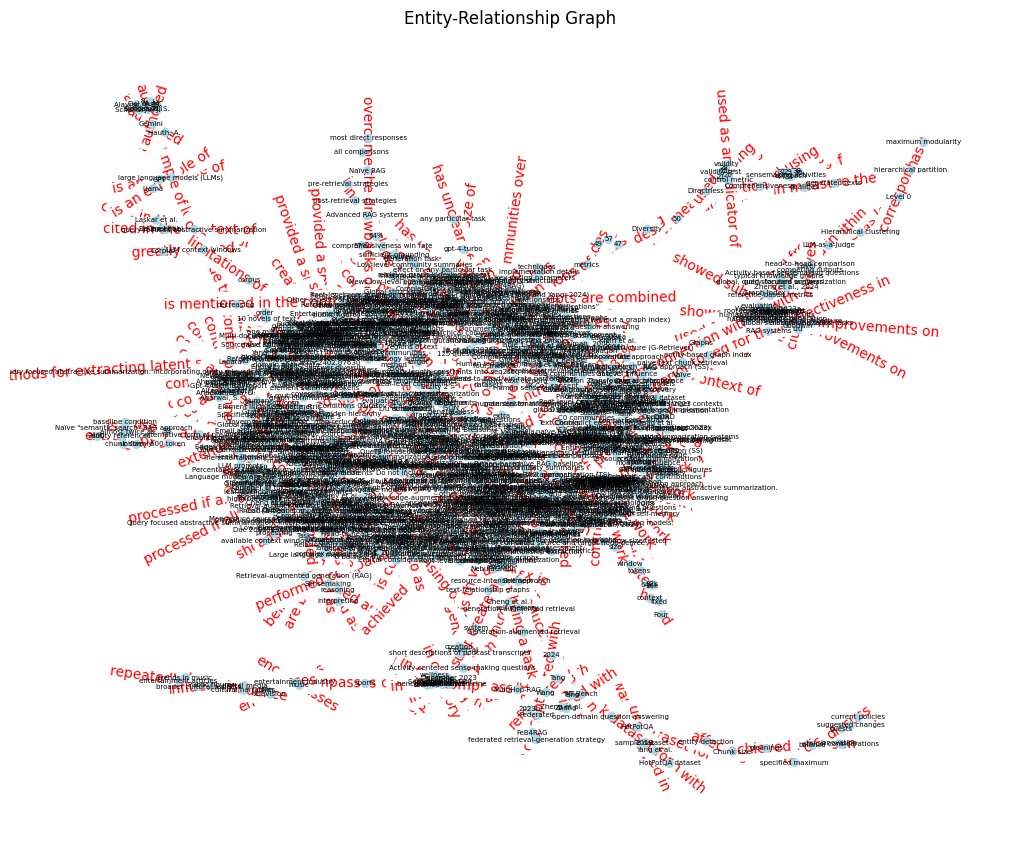

In [5]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(graph)
labels = nx.get_edge_attributes(graph, 'label')

plt.figure(figsize=(10, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=30, font_size=5, edge_color='gray')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='red')
plt.title("Entity-Relationship Graph")
plt.show()


In [6]:
from collections import Counter

# Check for nodes with same lowercased name
node_names = [node.lower() for node in graph.nodes()]
duplicates = [item for item, count in Counter(node_names).items() if count > 1]
print("Possible duplicate nodes (by name):", duplicates)


Possible duplicate nodes (by name): ['retrieval-augmented generation (rag)', 'large language models (llms)', 'external knowledge source', 'graph rag', 'query-focused summarization', 'retrieval-augmented generation', 'large language models', 'query-focused summarization (qfs)', 'entity knowledge graph', 'community summaries', 'graph rag approach', 'source documents', 'questions', 'scientific discovery', 'intelligence analysis', 'source document text', 'community detection', 'graph index', 'nodes', 'edges', 'covariates', 'global answer', 'query', 'factual relationships', 'data', 'query-focused abstractive summarization', 'datasets', 'text', 'extract', 'transformer architecture', 'state-of-the-art', 'corpus', 'context window', 'in-context learning', 'global summarization', 'knowledge graph', 'closely-related nodes', 'community detection algorithms', 'gpt-4-turbo', 'chunk size', 'map-reduce approach', 'llm (large language model)', 'activity-centered sense-making questions', 'news articles'

In [7]:
isolated_nodes = list(nx.isolates(graph))
print("Isolated nodes:", isolated_nodes)

Isolated nodes: ['@microsoft.com', 'External knowledge source', 'Query-focused summarization (QFS)', 'Private text corpora', 'Entity knowledge graph', 'Open-source, Python-based implementation', 'Scientific discovery', 'Intelligence analysis', 'Microsoft, 2023', 'Ranade and Joshi, 2023', 'Source document text', 'Nodes (e.g., entities)', 'Edges (e.g., relationships)', 'Covariates (e.g., claims)', 'Traag et al.', 'Nodes', 'Edges', 'Covariates', 'Global answer', 'Query', 'Data', 'Lewis et al., 2020', 'Dang, 2006', 'Transformer architecture', 'State-of-the-art', 'Goodwin et al.', 'Context window', 'Kuratov et al.', 'Liu et al.', 'Global summarization', 'Knowledge graph', 'Newman, 2006', 'Louvain, Blondel et al., 2008', 'Leiden, Traag et al., 2019', 'Closely-related nodes', 'Map-reduce approach', 'LLM (Large language model)', 'Diver', 'Source texts', 'Global map-reduce summarization', 'LLM prompts', 'Extraction', 'Recall degradation', 'Single extraction round', 'Zero gleanings', 'Sample dat

In [11]:
len(graph.nodes), len(duplicates), len(isolated_nodes)

(1228, 184, 266)

In [14]:
import networkx as nx

def unify_duplicate_nodes(G, key_func=None):
    """
    Unifies duplicate nodes in a graph based on a key function.

    Args:
        G (nx.DiGraph or nx.Graph): Input graph.
        key_func (function): Optional function that returns the canonical key for unification.
                             If None, will use node labels directly (case-insensitive).

    Returns:
        G (nx.DiGraph or nx.Graph): Graph with unified nodes.
    """
    if key_func is None:
        # Default: lowercase label stripping whitespace
        key_func = lambda x: x.lower().strip()

    # Group nodes by their normalized form
    from collections import defaultdict
    groups = defaultdict(list)

    for node in list(G.nodes):
        key = key_func(node)
        groups[key].append(node)

    for key, dupes in groups.items():
        if len(dupes) > 1:
            # Pick one canonical node
            canonical = dupes[0]
            for dupe in dupes[1:]:
                # Redirect incoming edges
                for pred in list(G.predecessors(dupe)):
                    G.add_edge(pred, canonical, **G.get_edge_data(pred, dupe))

                # Redirect outgoing edges
                for succ in list(G.successors(dupe)):
                    G.add_edge(canonical, succ, **G.get_edge_data(dupe, succ))

                # Remove the duplicate node
                G.remove_node(dupe)

    return G

graph_pure = unify_duplicate_nodes(graph, key_func=None)

In [15]:
len(graph_pure.nodes), len(graph_pure.edges)

(1039, 1244)

In [9]:
!pip install leidenalg igraph

In [17]:
from igraph import Graph as IGraph
import leidenalg

def communities_detection(graph):
    """
      Detects communities (clusters of related entities) in the graph using the Leiden algorithm.

      Inputs:
        graph (networkx.Graph): The knowledge graph.
      Output:
        List of communities, each a list of entity names.
    """
    communities = []
    index = 0
    for component in nx.connected_components(graph.to_undirected()):
        ############### Your Code - 30 pts #############################
        subgraph = graph.subgraph(component)

        # Convert to igraph
        mapping = {node: i for i, node in enumerate(subgraph.nodes)}
        reverse_mapping = {i: node for node, i in mapping.items()}
        edges = [(mapping[u], mapping[v]) for u, v in subgraph.edges]

        ig = IGraph(edges=edges)
        partition = leidenalg.find_partition(ig, leidenalg.ModularityVertexPartition)

        for community in partition:
            community_nodes = [reverse_mapping[node_id] for node_id in community]
            communities.append(community_nodes)
        #######################################################
    return communities


communities = communities_detection(graph)

In [18]:
len(communities)

131

`4. Graph Communities → Community Summaries`

  summarize each detected community.

In [19]:
def communities_summerization(communities, graph):


    """
      Creates a textual summary for each community based on its entities and their relationships.
      Inputs:
        communities (list of list): Communities detected from the graph.
        graph (networkx.Graph): The knowledge graph with edges and labels.
      Output:
        List of string summaries for each community.
    """
    community_summaries = []
    for index, community in enumerate(communities):
        ############### Your Code - 10 pts #############################
        entities = sorted(community)
        summary_lines = [f"Community {index + 1} Summary:", "**Entities:**"]
        summary_lines.extend([f"- {entity}" for entity in entities])

        summary_lines.append("\n**Relationships:**")
        seen_edges = set()
        for node in community:
            for neighbor in graph.neighbors(node):
                if neighbor in community and (neighbor, node) not in seen_edges:
                    edge_data = graph.get_edge_data(node, neighbor)
                    label = edge_data.get("label", "related")
                    summary_lines.append(f"- {node} -> {neighbor}: {label}")
                    seen_edges.add((node, neighbor))

        summary = "\n".join(summary_lines)
        community_summaries.append(summary)
        print(summary)
        #######################################################
    return community_summaries

community_summaries = communities_summerization(communities, graph)

Community 1 Summary:
**Entities:**
- 26-33%
- 9x-43x
- C0
- C1
- C2
- C3
- DSP
- From Local to Global: A Graph RAG Approach to Query-Focused Summarization
- High-level community summaries
- IR-CoT
- ITRG
- Kim et al., 2023
- Knowledge graph generation
- Low-level community summaries (C3)
- Microsoft Office of the CTO
- Microsoft Research
- Microsoft Strategic Missions and Technologies
- Multi-hop question answering
- Other methods
- Query-focused summarization (QFS)
- RAPTOR
- Root-level community summaries
- Root-level community summaries (C0)
- Sarthi et al., 2024
- answering multiple interpretations of ambiguous questions
- clustering the vectors of text embeddings
- concepts
- conditions
- context tokens
- creation
- data types
- dataset sizes
- generating a hierarchical index of text chunks
- generating a tree of clarifications
- global approach
- graph RAG
- head-to-head results
- human interaction
- multiple concepts
- other global methods
- performance
- question types
- system

`6. Community Summaries → Community Answers → Global Answer`

  Finally, we generate answers from community summaries and combine them into a final global answer.

In [22]:
def generate_final_answer(community_summaries, query):

    """
      Answers a query by using each community summary, then aggregates all answers.
      Inputs:
        community_summaries (list of str): Summaries of each community.
        query (str): The user query.
      Output:
        A final answer string synthesized from all community-based answers.
    """
    intermediate_answers = []
    for index, summary in enumerate(community_summaries):
        ############### Your Code - 10 pts #############################
        if len(intermediate_answers) > 1:
          break
        content = (
            f"Based on the following community summary, answer the query concisely:\n\n"
            f"{summary}\n\n"
            f"Query: {query}\n"
            f"Only respond if the summary contains relevant information."
            f"If the summary does not contain relevant information, respond with EXACTLY: [NO RELEVANT INFO]\n\n"
        )
        response = get_response(query, content)
        if not "[NO RELEVANT INFO]" in response:
          print("-> Answer Based on summary ", index+1, ":\n ", response, "\n")

        if not ("[NO RELEVANT INFO]" in response) and response and response.strip():
                intermediate_answers.append(response.strip())

    if not intermediate_answers:
        return "No relevant information was found in the community summaries to answer the query."

    combined_answers = " ".join(intermediate_answers)
    synthesis_prompt = (
        f"Given the following answers from different community summaries:\n\n"
        f"{combined_answers}\n\n"
        f"Please synthesize these into one coherent, concise answer to the query:\n"
        f"{query}"
    )

    final_answer = get_response(query, synthesis_prompt)
    #######################################################

    return final_answer


In [21]:
query = "What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?"
print('Query:', query)
final_answer = generate_final_answer(community_summaries, query)
print("Answer: ", final_answer)

Query: What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?
-> Answer Based on summary  1 :
  [NO RELEVANT INFO] 

-> Answer Based on summary  2 :
  [NO RELEVANT INFO] 

-> Answer Based on summary  3 :
  [NO RELEVANT INFO] 

-> Answer Based on summary  4 :
  [NO RELEVANT INFO] 

-> Answer Based on summary  5 :
  [NO RELEVANT INFO] 

-> Answer Based on summary  6 :
  Community detection algorithms are used to partition the Graph, which is a key part of the Graph RAG framework. They are formed by modular communities and may be used to partition the Graph. 

-> Answer Based on summary  7 :
  [NO RELEVANT INFO] 

-> Answer Based on summary  8 :
  The Leiden hierarchy is created for each community in community summaries, and the Leiden hierarchy provides a community partition. Community partition covers the nodes of the graph and is mutually-exclusive and collective-exhaustive. Thus, community detection algorithms like Leiden are used to par

#### Analyze the proposed method for these questions. `10 pts`

- What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?

- How does the Graph RAG architecture overcome the limitations of LLM context windows?

- What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?

- How does Graph RAG differ from previous QFS or graph-based retrieval approaches?

- What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?

- How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?

- What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?

- Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?

- How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?

- Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?

- In what ways does the modularity of graphs enable better summarization in the context of large corpora?

- How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?

In [23]:
questions = [
    "What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?",
    "How does the Graph RAG architecture overcome the limitations of LLM context windows?",
    "What are the key steps in the Graph RAG pipeline, and how are they distributed between indexing time and query time?",
    "How does Graph RAG differ from previous QFS or graph-based retrieval approaches?",
    "What role do community detection algorithms (e.g., Leiden or Louvain) play in the Graph RAG framework?",
    "How does the performance of Graph RAG scale with increasing corpus size (e.g., 1M tokens)?",
    "What kind of summaries are generated during each stage of the Graph RAG pipeline, and how are they used?",
    "Why is the distinction between ‘local’ and ‘global’ queries important in the design of Graph RAG?",
    "How does entity extraction using GPT-4-turbo vary with chunk sizes in the HotPotQA dataset, as shown in Figure 2?",
    "Why do the authors claim that query-focused abstractive summarization is more appropriate than retrieval-based generation for global questions?",
    "In what ways does the modularity of graphs enable better summarization in the context of large corpora?",
    "How does Graph RAG contribute to the broader goal of sensemaking in domains like scientific discovery or intelligence analysis?"
]
for i, question in enumerate(questions, 1):
    print(f"Question {i}: {question}\n")
    answer = generate_final_answer(community_summaries[:114], question)
    print(f"Answer {i}: {answer}\n{'-'*80}\n")

Question 1: What problem does Graph RAG aim to solve that traditional RAG and QFS methods cannot?

-> Answer Based on summary  4 :
  The summary indicates that a Graph RAG Approach is related to query-focused summarization and is about addressing challenges in query-focused abstractive summarization, particularly the limitation of LLM context windows. Traditional RAG and QFS methods may struggle with this limitation, while the Graph RAG Approach is designed to handle it more effectively. Therefore, the problem Graph RAG aims to solve is the challenge of handling long texts within LLM context windows in query-focused abstractive summarization. 

-> Answer Based on summary  5 :
  Graph RAG aims to solve the problem of handling complex, interconnected information by leveraging graph structures to capture relationships between entities, which traditional RAG and QFS methods may not effectively handle due to their limitations in representing and querying such relationships. 

-> Answer Base